### Загрузка данных

In [1]:
%mkdir data
!wget https://s3-us-west-2.amazonaws.com/ai2-s2-research-public/open-corpus/2021-03-01/manifest.txt
! ./script.sh manifest.txt

### Обработка и запись в pandas

In [2]:
import gzip
import os
import json
from collections import defaultdict
from tqdm.auto import tqdm
import pandas as pd
import string
import numpy as np

In [3]:
with open("manifest.txt", "r") as f:
    file_names = list(map(str.strip, f.readlines()[:30]))

In [4]:
lines = []
for item in tqdm(file_names[:30]):
    with gzip.open(f'data/{item}', "r") as f:
        lines.extend(f.readlines())

  0%|          | 0/30 [00:00<?, ?it/s]

In [5]:
json.loads(lines[0])

{'id': '33b237709dbd53953a750355115b57ccb6690da1',
 'title': 'USING PHOTO IMAGES TO DETERMINE THE GEOMETRIC PARAMETERS OF LARGE OBJECTS',
 'paperAbstract': '',
 'authors': [{'name': 'E  Popov', 'ids': ['144112922']},
  {'name': 'O  Raskatkina', 'ids': ['108722565']}],
 'inCitations': [],
 'outCitations': [],
 'year': 2019,
 's2Url': 'https://semanticscholar.org/paper/33b237709dbd53953a750355115b57ccb6690da1',
 'sources': [],
 'pdfUrls': [],
 'venue': '',
 'journalName': '',
 'journalVolume': '19',
 'journalPages': '45-54',
 'doi': '10.14529/build190307',
 'doiUrl': 'https://doi.org/10.14529/build190307',
 'pmid': '',
 'fieldsOfStudy': ['Computer Science'],
 'magId': '3000193832',
 's2PdfUrl': '',
 'entities': []}

### Data Processing

В данной части происходит базовая подготовка данных, чтобы внести их в базовый (максимально полный) датафрейм. Это нужно для того, чтобы удобнее сохранить эти данные в csv. Позже не нужно будет каждый раз загружать и читать занова 30 файлов.

In [6]:
transtab = str.maketrans(string.punctuation, " " * len(string.punctuation))

def prepare_text(text):
    return " ".join(text.translate(transtab).lower().strip().split())

def prepare_authors(data):
    result = []
    for item in data:
        ind = None if not len(item['ids']) else item['ids'][0]
        result.append((item['name'], ind))
    return result

In [7]:
def default_gen():
    return lambda x: x

process_fn = defaultdict(default_gen)

process_fn.update({
    'title': prepare_text,
    'paperAbstract': prepare_text, 
    'authors': prepare_authors,
    'journalPages': prepare_text,
})


def make_dataframe(lines):
    data = defaultdict(list)
    for line in tqdm(lines):
        tmp = json.loads(line)
        for key in tmp:
            data[key].append(process_fn[key](tmp[key]))
    return data

In [8]:
df = make_dataframe(lines)

  0%|          | 0/954657 [00:00<?, ?it/s]

In [9]:
data = pd.DataFrame(data=df)

In [10]:
data.head()

,id,title,paperAbstract,authors,inCitations,outCitations,year,s2Url,sources,pdfUrls,...,journalName,journalVolume,journalPages,doi,doiUrl,pmid,fieldsOfStudy,magId,s2PdfUrl,entities
0,33b237709dbd53953a750355115b57ccb6690da1,using photo images to determine the geometric ...,,"[(E Popov, 144112922), (O Raskatkina, 108722...",[],[],2019.0,https://semanticscholar.org/paper/33b237709dbd...,[],[],...,,19,45 54,10.14529/build190307,https://doi.org/10.14529/build190307,,[Computer Science],3000193832,,[]
1,062e9c7579adc73129e1198671d05905f07d4ab5,clinical or industrial pharmacy case studies o...,automated medication dispensing systems for ho...,"[(J Novek, 47586327)]","[799bde07f3e9dc7f39d30ae9e1ac29cda9cd5a5c, 59a...","[a402dac75befed8c389fe00a3b6eed7ee8da87e1, 7d9...",1998.0,https://semanticscholar.org/paper/062e9c7579ad...,[Medline],[],...,International Journal of Health Services,28,445 465,10.2190/W2BT-FGXQ-QL0G-YNL9,https://doi.org/10.2190/W2BT-FGXQ-QL0G-YNL9,9711475,[Medicine],1988383910,,[]
2,771723e7e2d9ed97d09442086553b726f0dd6657,noncoronary and coronary atherothrombotic plaq...,in the future the use of imaging methods to qu...,"[(Zahi A Fayad, 1886137)]","[ba2cbbac306fa374c7c07da398e31a52c5680a58, 494...","[3109764f646de80e096609f86b5e4bf19320c81c, aea...",2002.0,https://semanticscholar.org/paper/771723e7e2d9...,[Medline],[],...,Neuroimaging clinics of North America,12 3,461 71,10.1016/S1052-5149(02)00023-0,https://doi.org/10.1016/S1052-5149%2802%2900023-0,12486833,[Medicine],1983175018,,[]
3,263f70167ba7def67a2843ffc30c80a0b9b3f617,국어 명사구 접속의 연구,,"[(최재희, 115087709)]",[],[],1985.0,https://semanticscholar.org/paper/263f70167ba7...,[],[],...,,,,,,,[],2291560164,,[]
4,9ea1148fa657103879ef7ed9a5b716be48ee13a4,who ll take my place when i m gone,,"[(Billy Fazioli, 146257415), (Raymond Klages...",[],[],2018.0,https://semanticscholar.org/paper/9ea1148fa657...,[],[https://digitalcommons.library.umaine.edu/cgi...,...,,,,,,,[Art],1489188979,,[]


In [11]:
data.pmid = data.pmid.astype(str)
data.magId = data.magId.astype(str)
data.year = data.year.replace({np.nan: -1})

In [12]:
%%time
data.to_csv("df_full.csv", sep='\t', index=False)

CPU times: user 35.9 s, sys: 2.99 s, total: 38.9 s
Wall time: 40 s


### Prepare file with citations info

In [13]:
article_years = {ind: year for ind, year in zip(data.id, data.year)}

def get_first_5years_citations(year, in_cit_ls):
    if year < 0:
        return None, None
    res = 0
    out_of_files = 0
    for ind in in_cit_ls:
        if ind in article_years:
            res += article_years[ind] > 0 and article_years[ind] - year <= 5
        else:
            out_of_files += 1
    return res, out_of_files   

In [14]:
def make_citations_dataframe(data):
    result = data[['id', 'year', 'inCitations', 'outCitations']]
    result = result[result.year <= 2016]
    target, out_of_files, count_in, count_out = [], [], [], []
    for year, inls, outls in tqdm(zip(result.year, result.inCitations, result.outCitations)):
        res, out_of_file = get_first_5years_citations(year, inls)
        target.append(res)
        out_of_files.append(out_of_file)
        count_in.append(len(inls))
        count_out.append(len(outls))
    result['target'] = target
    result['out_of_files'] = out_of_files
    result['count_in'] = count_in
    result['count_out'] = count_out
    return result

In [15]:
cit_df = make_citations_dataframe(data)

0it [00:00, ?it/s]

In [16]:
%%time
cit_df.to_csv("df_citations.csv", sep='\t', index=False)

CPU times: user 16.2 s, sys: 1.8 s, total: 18 s
Wall time: 19.1 s


Несколько вспомогательных функций и образец того, как правильно считать полный датафрейм. Проблема там возникает в том, что после записи списки перестают быть списками. 

In [17]:
%%time

def process_authors(text):
    result = []
    for item in text.strip('[()]').replace("'","").split('), ('):
        try:
            name, ind = item.rsplit(', ')
        except:
            return []
        result.append((name, int(ind) if ind != 'None' else None))
    return result

converter = lambda x: json.loads(x.replace("'", '"'))
converter_pdf_urls = lambda x: x.strip("[]").replace("'","").split(", ")
converter_authors = lambda x: process_authors(x)

data = pd.read_csv('df_full.csv', sep='\t', converters={
    'sources': converter,
    'inCitations': converter,
    'outCitations': converter,
    'pdfUrls': converter_pdf_urls,
    'fieldsOfStudy': converter,
    'entities': converter,
    'authors': converter_authors,
})

CPU times: user 44.4 s, sys: 19.9 s, total: 1min 4s
Wall time: 1min 13s


### Prepare for training

В планах для тренировки было использовать собранные и полученные после парсинга данные, но проблема возникла в тот момент, когда выяснилось, что большинство входящих цитат для статей идут из других файлов. Поэтому данными статей воспользоваться не получится. Буду строить предсказания на таблице, предложенной в задании. Вообще, для при построении фичей по исходным статьям я планировал выделить следующие признаки: 

* язык статьи (c помощью пакета `langdetect`)
* количество авторов
* цитируемости авторов 
* среднюю цитируемость для каждого издания
* среднюю цитируемость каждого топика статьи
* сгруппировать авторов по странам и для каждой статьи записать средннюю цитируемости авторов по странам
* различные текстовые характеристики: кол-во слов, длину в символах, векторные представления названий (тут могут возникнуть проблемы с разными языками)
* количество ссылок, связанных со статьей и т.д.

Еще также разумным было бы отсеять статьи, которых не указан год или издание. 

### Training

In [18]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from scipy.stats import zscore

from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor

import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
df = pd.read_csv('predict.csv')

In [20]:
df

,recency,topic_rank,diversity,authors_mean_rank,authors_mean_hindex,authors_mean_gindex,authors_mean_sociality,authors_mean_pagerank,authors_mean_productivity,journal_pagerank,journal_rank,title_len,abstract_len,n_authors,c5,log_authors_mean_sociality
0,16,1.0,-0.425436,500.0,1.0,1.0,6.0,NaN,NaN,NaN,101.0,66,1653,7,1.0,1.945910
1,8,7.0,-0.571967,134.0,1.0,1.0,6.0,NaN,NaN,NaN,24.0,59,1527,7,32.0,1.945910
2,15,19.0,-0.859644,235.0,1.0,1.0,5.0,NaN,NaN,NaN,49.0,169,1554,6,5.0,1.791759
3,6,4.0,-1.054999,1124.0,1.0,1.0,10.0,NaN,NaN,NaN,185.0,130,2121,11,7.0,2.397895
4,14,2.0,-0.476697,346.0,1.0,1.0,2.0,NaN,NaN,NaN,72.0,100,432,3,7.0,1.098612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,25,6.0,-0.330948,528.0,0.0,0.0,6.0,NaN,NaN,NaN,140.0,62,645,7,0.0,1.945910
475,6,12.0,-1.493480,2145.0,0.0,0.0,1.0,NaN,NaN,NaN,416.0,45,714,2,0.0,0.693147
476,24,17.0,-1.466320,551.0,0.0,0.0,4.0,NaN,NaN,NaN,146.0,84,0,5,0.0,1.609438
477,24,6.0,-1.556737,551.0,0.0,0.0,0.0,NaN,NaN,NaN,146.0,56,0,1,0.0,0.000000


In [21]:
X = df.drop(columns=['c5', 'authors_mean_pagerank', 'authors_mean_productivity', 'journal_pagerank'])
y = df.c5

<AxesSubplot:>

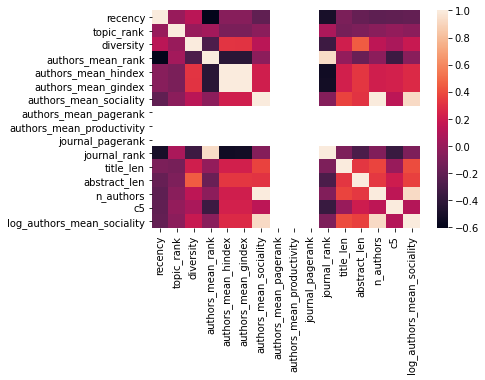

In [22]:
sns.heatmap(df.corr())

Уберем выбросы из обучающей выборки, чтобы модель была более устойчивой. 

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=73, test_size=0.2)
ind = abs(zscore(y_train)) < 3

X_train = X_train[ind]
y_train = y_train[ind]

Базовые модели, которые будем использовать:

* Ridge
* CatBoostRegressor
* RF
* XGBRegressor
* GradientBoostingRegressor

In [24]:
ridge_pipe = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

rf_pipe =  Pipeline([
    ('imputer', SimpleImputer()),
    ('rf', RandomForestRegressor(random_state=0))
])

grad_pipe =  Pipeline([
    ('imputer', SimpleImputer()),
    ('grad', GradientBoostingRegressor(random_state=0))
])

xgb_model = XGBRegressor()

catb_model = CatBoostRegressor(verbose=0)

In [25]:
columns = X_train.columns
print(columns)

Index(['recency', 'topic_rank', 'diversity', 'authors_mean_rank',
       'authors_mean_hindex', 'authors_mean_gindex', 'authors_mean_sociality',
       'journal_rank', 'title_len', 'abstract_len', 'n_authors',
       'log_authors_mean_sociality'],
      dtype='object')


In [26]:
def check_test(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    return r2_score(y_test, model.predict(X_test))

def cross_val_model(model, X_train, y_train, scoring, cv):
    ls = cross_val_score(model, X_train, y_train, scoring=scoring, cv=cv)
    print(f"{scoring} = {np.mean(ls)} +- {np.std(ls)}")

In [27]:
%%time
cross_val_model(catb_model, X_train[columns], y_train, scoring='r2', cv=5)

r2 = 0.6826869564088899 +- 0.06160971573918031
CPU times: user 31.8 s, sys: 5.13 s, total: 37 s
Wall time: 12.7 s


In [28]:
check_test(catb_model, X_train[columns], y_train, X_test[columns], y_test)

0.5986357179888994

In [29]:
%%time
cross_val_model(xgb_model, X_train[columns], y_train, scoring='r2', cv=5)

r2 = 0.6126552522081382 +- 0.09488050455873043
CPU times: user 6.9 s, sys: 557 ms, total: 7.46 s
Wall time: 1.65 s


In [30]:
check_test(xgb_model, X_train[columns], y_train, X_test[columns], y_test)

0.5783276651759164

In [31]:
%%time
cross_val_model(rf_pipe, X_train[columns], y_train, scoring='r2', cv=5)

r2 = 0.6739585881948266 +- 0.08748509832545126
CPU times: user 1.95 s, sys: 82.5 ms, total: 2.03 s
Wall time: 872 ms


In [32]:
check_test(rf_pipe, X_train[columns], y_train, X_test[columns], y_test)

0.6389453200165476

In [33]:
%%time
cross_val_model(grad_pipe, X_train[columns], y_train, scoring='r2', cv=5)

r2 = 0.7141653885495068 +- 0.0850534786014533
CPU times: user 342 ms, sys: 5.69 ms, total: 347 ms
Wall time: 350 ms


In [34]:
check_test(grad_pipe, X_train[columns], y_train, X_test[columns], y_test)

0.6452951504017186

In [35]:
%%time
cross_val_model(ridge_pipe, X_train[columns], y_train, scoring='r2', cv=5)

r2 = 0.610241154764583 +- 0.07652869738039728
CPU times: user 44.2 ms, sys: 3.91 ms, total: 48.1 ms
Wall time: 52.3 ms


In [36]:
check_test(ridge_pipe, X_train[columns], y_train, X_test[columns], y_test)

0.43977961982334524

После сравнения бейзлайнов имеет смысл подбирать параметры для моделей rf, grad.

### GradientBoostingRegressor

In [37]:
gbm_params = {}

In [38]:
param_test1 = {'grad__n_estimators':range(20, 150, 10)}

gsearch1 = GridSearchCV(estimator = grad_pipe.set_params(**gbm_params), 
param_grid = param_test1, scoring='r2', cv=5)
gsearch1.fit(X_train[columns], y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('grad',
                                        GradientBoostingRegressor(random_state=0))]),
             param_grid={'grad__n_estimators': range(20, 150, 10)},
             scoring='r2')

In [39]:
gsearch1.best_params_, gsearch1.best_score_

({'grad__n_estimators': 60}, 0.7184824570806045)

In [40]:
gbm_params.update(gsearch1.best_params_)

In [41]:
param_test2 = {
    'grad__max_depth': range(2, 16, 2),
    'grad__min_samples_split': range(10, 51, 10),
}


gsearch2 = GridSearchCV(estimator = grad_pipe.set_params(**gbm_params), param_grid=param_test2, scoring='r2', cv=5)
gsearch2.fit(X_train[columns], y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('grad',
                                        GradientBoostingRegressor(n_estimators=60,
                                                                  random_state=0))]),
             param_grid={'grad__max_depth': range(2, 16, 2),
                         'grad__min_samples_split': range(10, 51, 10)},
             scoring='r2')

In [42]:
gsearch2.best_params_, gsearch2.best_score_

({'grad__max_depth': 4, 'grad__min_samples_split': 40}, 0.7328010519365253)

In [43]:
gbm_params.update(gsearch2.best_params_)

In [44]:
param_test3 = {
    'grad__min_samples_leaf': range(1, 50, 5),
    'grad__min_samples_split': range(10, 51, 10),
}

gsearch3 = GridSearchCV(estimator = grad_pipe.set_params(**gbm_params), param_grid=param_test3, scoring='r2', cv=5)
gsearch3.fit(X_train[columns], y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('grad',
                                        GradientBoostingRegressor(max_depth=4,
                                                                  min_samples_split=40,
                                                                  n_estimators=60,
                                                                  random_state=0))]),
             param_grid={'grad__min_samples_leaf': range(1, 50, 5),
                         'grad__min_samples_split': range(10, 51, 10)},
             scoring='r2')

In [45]:
gsearch3.best_params_, gsearch3.best_score_

({'grad__min_samples_leaf': 1, 'grad__min_samples_split': 40},
 0.7328010519365253)

In [46]:
gbm_params.update(gsearch3.best_params_)

In [47]:
param_test4 = {
    'grad__max_features': ['sqrt', 'auto', 'log2'],
}

gsearch4 = GridSearchCV(estimator = grad_pipe.set_params(**gbm_params), param_grid=param_test4, scoring='r2', cv=5)
gsearch4.fit(X_train[columns], y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('grad',
                                        GradientBoostingRegressor(max_depth=4,
                                                                  min_samples_split=40,
                                                                  n_estimators=60,
                                                                  random_state=0))]),
             param_grid={'grad__max_features': ['sqrt', 'auto', 'log2']},
             scoring='r2')

In [48]:
gsearch4.best_params_, gsearch4.best_score_

({'grad__max_features': 'auto'}, 0.7328010519365253)

In [49]:
gbm_params.update(gsearch4.best_params_)

In [50]:
param_test5 = {
    'grad__n_estimators': range(50, 1000, 50),
}

gsearch5 = GridSearchCV(estimator = grad_pipe.set_params(**gbm_params), param_grid=param_test5, scoring='r2', cv=5)
gsearch5.fit(X_train[columns], y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('grad',
                                        GradientBoostingRegressor(max_depth=4,
                                                                  max_features='auto',
                                                                  min_samples_split=40,
                                                                  n_estimators=60,
                                                                  random_state=0))]),
             param_grid={'grad__n_estimators': range(50, 1000, 50)},
             scoring='r2')

In [51]:
gsearch5.best_params_, gsearch5.best_score_

({'grad__n_estimators': 100}, 0.7329996865332408)

In [52]:
gbm_params.update(gsearch5.best_params_)

In [53]:
gbm_params

{'grad__n_estimators': 100,
 'grad__max_depth': 4,
 'grad__min_samples_split': 40,
 'grad__min_samples_leaf': 1,
 'grad__max_features': 'auto'}

In [54]:
cross_val_model(grad_pipe.set_params(**gbm_params), X_train[columns], y_train, scoring='r2', cv=5)

r2 = 0.7329996865332408 +- 0.11144137357215075


In [55]:
model = grad_pipe.set_params(**gbm_params)

check_test(model, X_train[columns], y_train, X_test[columns], y_test)

0.6709337823313424

### Random Forest

In [56]:
rf_final = {}

rf_params = {
    'rf__criterion': ['mse', 'mae'],
    'rf__min_samples_split': range(2, 11, 2),
    'rf__min_samples_leaf': range(1, 10, 2),
    'rf__max_features': ['auto', 'sqrt', 'log2'],
}

gsearch_rf = GridSearchCV(estimator=rf_pipe, param_grid=rf_params, scoring='r2', cv=5, verbose=1)
gsearch_rf.fit(X_train[columns], y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('rf',
                                        RandomForestRegressor(random_state=0))]),
             param_grid={'rf__criterion': ['mse', 'mae'],
                         'rf__max_features': ['auto', 'sqrt', 'log2'],
                         'rf__min_samples_leaf': range(1, 10, 2),
                         'rf__min_samples_split': range(2, 11, 2)},
             scoring='r2', verbose=1)

In [57]:
gsearch_rf.best_score_, gsearch_rf.best_params_

(0.6762408986281828,
 {'rf__criterion': 'mse',
  'rf__max_features': 'auto',
  'rf__min_samples_leaf': 1,
  'rf__min_samples_split': 4})

In [58]:
rf_final.update(gsearch_rf.best_params_)

In [59]:
rf_params_estimators = {
    'rf__n_estimators': range(50, 1000, 100),
}

gsearch_rf_est = GridSearchCV(estimator=rf_pipe.set_params(**rf_final), param_grid=rf_params_estimators, scoring='r2', cv=5, verbose=1)
gsearch_rf_est.fit(X_train[columns], y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('rf',
                                        RandomForestRegressor(min_samples_split=4,
                                                              random_state=0))]),
             param_grid={'rf__n_estimators': range(50, 1000, 100)},
             scoring='r2', verbose=1)

In [60]:
gsearch_rf_est.best_score_, gsearch_rf_est.best_params_

(0.6936679114163861, {'rf__n_estimators': 750})

In [61]:
rf_final.update(gsearch_rf_est.best_params_)

In [62]:
rf_final

{'rf__criterion': 'mse',
 'rf__max_features': 'auto',
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 4,
 'rf__n_estimators': 750}

In [63]:
cross_val_model(rf_pipe.set_params(**rf_final), X_train[columns], y_train, scoring='r2', cv=5)

r2 = 0.6936679114163861 +- 0.08359443690904708


In [64]:
model = rf_pipe.set_params(**rf_final)

check_test(model, X_train[columns], y_train, X_test[columns], y_test)

0.6268549219656455

### Важность признаков

In [65]:
rf_model = rf_pipe.set_params(**rf_final)
gb_model = grad_pipe.set_params(**gbm_params)


rf_model.fit(X_train[columns], y_train)
gb_model.fit(X_train[columns], y_train)

Pipeline(steps=[('imputer', SimpleImputer()),
                ('grad',
                 GradientBoostingRegressor(max_depth=4, max_features='auto',
                                           min_samples_split=40,
                                           random_state=0))])

#### Важность признаков для RF

In [66]:
for imp, feature in reversed(sorted(zip(rf_model['rf'].feature_importances_, columns))):
    print(f'{imp} --- {feature}')

0.3855784087021679 --- authors_mean_rank
0.35197390540367135 --- recency
0.10809401962662567 --- journal_rank
0.03442752278133549 --- abstract_len
0.03138308338492164 --- diversity
0.027503161114144678 --- topic_rank
0.02257952578339816 --- title_len
0.010545445042690713 --- n_authors
0.010512785749506199 --- authors_mean_sociality
0.010045849234028471 --- log_authors_mean_sociality
0.0039139043764149 --- authors_mean_gindex
0.00344238880109476 --- authors_mean_hindex


#### Важность признаков для GradientBoostingRegressor

In [67]:
for imp, feature in reversed(sorted(zip(gb_model['grad'].feature_importances_, columns))):
    print(f'{imp} --- {feature}')

0.5392139804171512 --- authors_mean_rank
0.3738324371201833 --- recency
0.03761067762515614 --- journal_rank
0.013700272288607263 --- diversity
0.013670871590019429 --- abstract_len
0.007512795769323515 --- n_authors
0.0035690784033866703 --- authors_mean_sociality
0.0030759135844914583 --- topic_rank
0.003027013432746099 --- title_len
0.00239510045868097 --- log_authors_mean_sociality
0.0012863632496749127 --- authors_mean_hindex
0.0011054960605790508 --- authors_mean_gindex


#### Вывод

По данным важностям фичей видно, что наибольший вклад в цитируемость статей вносится новизной, средним рангом авторов и рангом журнала, что достаточно ожидаемо. Возможно, были бы значимыми фичами также год написания статьи или страна, а также текстовая информация или ключевые слова из статей.

### Blending of models

In [68]:
blend_params = np.linspace(0, 1, 11)

alpha_res = {}
for alpha in tqdm(blend_params):
    preds = alpha * gb_model.predict(X_test[columns]) + (1 - alpha) * rf_model.predict(X_test[columns])
    alpha_res[r2_score(y_test, preds)] = alpha

key = max(alpha_res)
print(f'Best blending: alpha = {alpha_res[key]}, result = {key}')

  0%|          | 0/11 [00:00<?, ?it/s]

Best blending: alpha = 1.0, result = 0.6709337823313424
